In [1]:
import sys
sys.path.append('../')
import torch
from tools.utils import manual_seed
import PIL
import PIL.Image

import numpy as np
import matplotlib.pyplot as plt
from tools.img import rgb2yuv, yuv2rgb, rgb_to_yuv, yuv_to_rgb
from torchvision.transforms.transforms import ToTensor
from tools.dataset import get_dataloader, get_dataset_class_and_scale, get_dataset_normalization, get_de_normalization
from omegaconf import OmegaConf
from tools.img import tensor2ndarray, ndarray2tensor
from torchmetrics import StructuralSimilarityIndexMeasure
from tools.dataset import get_dataloader
from tools.inject_backdoor import patch_trigger

manual_seed(42)
loss = StructuralSimilarityIndexMeasure

/home/chengyiqiu/miniconda3/envs/Diffusion-Backdoor-Embed/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
target_folder = '../' + 'results/gtsrb/inba/20241007025841_wind32'
path = f'{target_folder}/config.yaml'
config = OmegaConf.load(path)
manual_seed(config.seed)

device = f'cuda:{config.device}'
num_class, scale = get_dataset_class_and_scale(config.dataset_name)
if config.model == "resnet18":
    from models.preact_resnet import PreActResNet18
    net = PreActResNet18(num_classes=num_class).to(f'cuda:{config.device}')
elif config.model == "rnp":
    from models.resnet_cifar import resnet18
    net = resnet18(num_classes=num_class).to(f'cuda:{config.device}')
elif config.model == "repvgg":
    from repvgg_pytorch.repvgg import RepVGG
    net = RepVGG(num_blocks=[2, 4, 14, 1], num_classes=num_class, width_multiplier=[1.5, 1.5, 1.5, 2.75]).to(device=f'cuda:{config.device}')
else:
    raise NotImplementedError(config.model)
ld = torch.load(f'{target_folder}/results.pth', map_location=device)
net.load_state_dict(ld['model'])
net.to(device)

PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d

Load a example image and plot RGB channels.

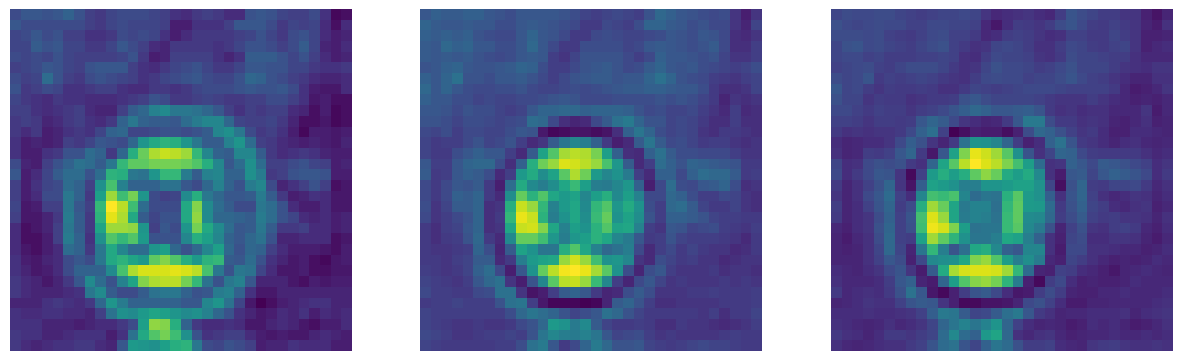

In [3]:
_, test_dl = get_dataloader(config.dataset_name, config.batch, False, 11)
x_c = None
for batch, label in iter(test_dl):
    for i in range(batch.shape[0]):
        if label[i] == 1:
            x_c = batch[i]
        if x_c != None:
            break
x_c = get_de_normalization(config.dataset_name)(x_c).squeeze()
x_c_nd = tensor2ndarray(x_c)
_, ax = plt.subplots(1, 3, figsize=(15, 10))
for i in range(x_c_nd.shape[-1]):
    ax[i].imshow(x_c_nd[:, :, i])
    ax[i].axis('off')
plt.show()

Convert the RGB image to YUV channels, and plot them.

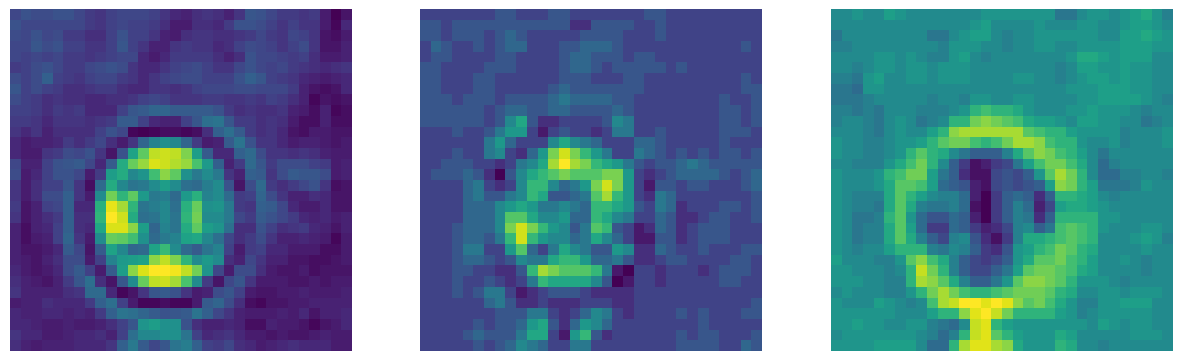

In [4]:
x_c_nd_yuv = rgb2yuv(x_c_nd)

_, ax = plt.subplots(1, 3, figsize=(15, 10))
for i in range(x_c_nd_yuv.shape[-1]):
    ax[i].imshow(x_c_nd_yuv[:, :, i])
    ax[i].axis('off')
plt.show()

Use INBA to add pertubation to the imaginary part of U channel after FFT.

Parameter containing:
tensor([[  0.0000,  -6.6347,  21.5424,  ..., -18.1289, -21.5424,   6.6347],
        [-26.4568,   9.6871,  15.1270,  ...,  20.2708,  17.6832,  -7.0794],
        [ 10.9005,  10.0735, -22.2530,  ...,  18.6515,   7.6058, -14.3599],
        ...,
        [-28.6167,  49.0358,   1.1367,  ...,  -1.2957, -18.5230,   1.7047],
        [-10.9005,  14.3599,  -7.6058,  ...,   4.0339,  22.2530, -10.0735],
        [ 26.4568,   7.0794, -17.6832,  ..., -18.1087, -15.1270,  -9.6871]],
       requires_grad=True)


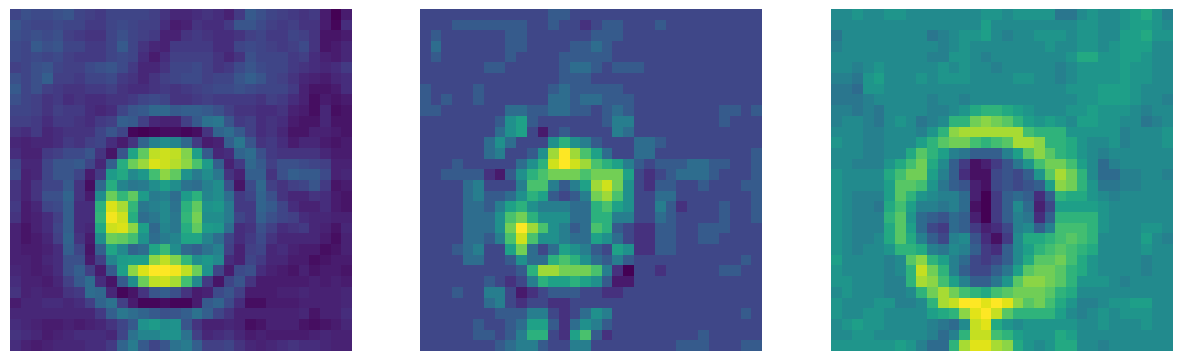

In [5]:
# x_torch = get_dataset_normalization(config.dataset_name)(x_c).clone()
x_torch = x_c.clone()
x_torch *= 255.
x_yuv = torch.stack(rgb_to_yuv(x_torch[0], x_torch[1], x_torch[2]), dim=0)
x_yuv = torch.clip(x_yuv, 0, 255)
tg: torch.tensor = torch.load(f'{target_folder}/trigger.pth')["tg_after"]
print(tg)
tg_size = config.attack.wind
tg_pos = 0
for ch in config.attack.target_channel:
    x_fft = torch.fft.fft2(x_yuv[ch].to(torch.float64))
    x_imag = torch.imag(x_fft)
    # x_imag[tg_pos:(tg_pos + tg_size), tg_pos:(tg_pos + tg_size)] = tg
    x_fft = torch.real(x_fft) + 1j * x_imag
    x_yuv[ch] = torch.real(torch.fft.ifft2(x_fft))
x_rgb = torch.stack(yuv_to_rgb(x_yuv[0], x_yuv[1], x_yuv[2]), dim=0)
x_rgb = torch.clip(x_rgb, 0, 255)
x_rgb /= 255.
x_p = x_rgb

x_yuv = rgb2yuv(tensor2ndarray(x_p))

_, ax = plt.subplots(1, 3, figsize=(15, 10))
for i in range(x_yuv.shape[-1]):
    ax[i].imshow(x_yuv[:, :, i])
    ax[i].axis('off')
plt.show()

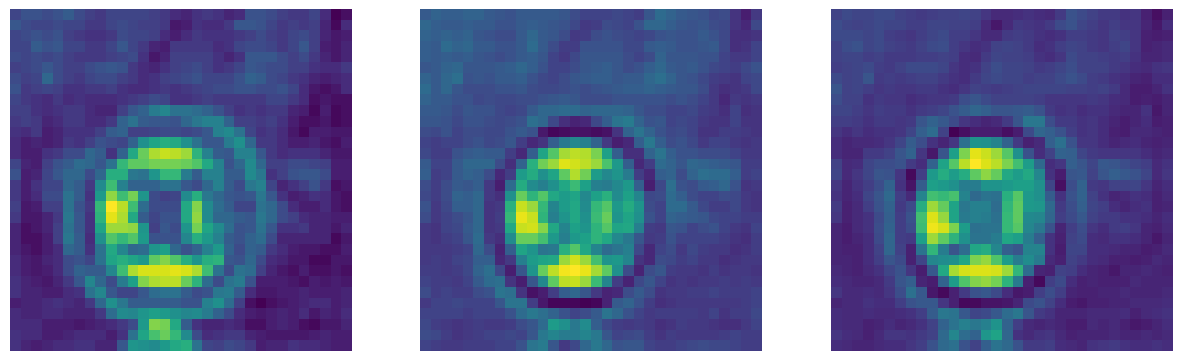

In [6]:
x_p_nd = tensor2ndarray(x_p)

_, ax = plt.subplots(1, 3, figsize=(15, 10))
for i in range(x_p_nd.shape[-1]):
    ax[i].imshow(x_p_nd[:, :, i])
    ax[i].axis('off')
plt.show()

1
1
tensor([[0.1255, 0.1333, 0.1333],
        [0.1333, 0.1255, 0.1255],
        [0.1216, 0.1255, 0.1333]], device='cuda:0')
tensor([[0.1255, 0.1333, 0.1333],
        [0.1333, 0.1255, 0.1255],
        [0.1216, 0.1255, 0.1333]], device='cuda:0')
tensor(7.5164e-08, device='cuda:0')


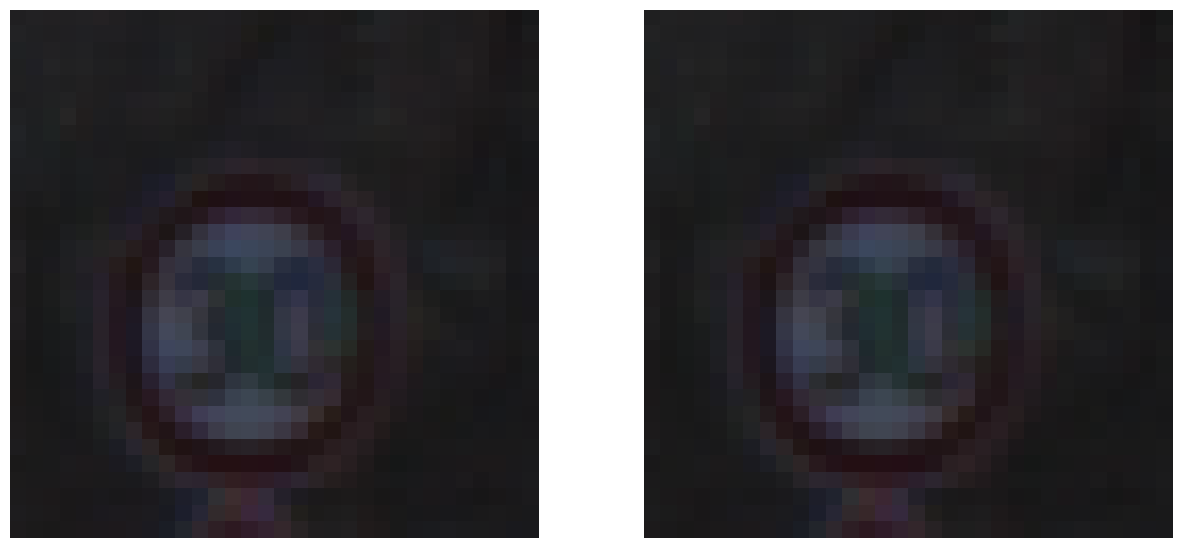

ssim: 1.0


/home/chengyiqiu/miniconda3/envs/Diffusion-Backdoor-Embed/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


In [7]:


# x_c = x_c.to(torch.float64)
x_c = get_dataset_normalization(config.dataset_name)(x_c)
x_p = patch_trigger(x_c, config)
# when training, we do not perform normalization to poison images, which is the same as BackdoorBench.

x_c = x_c.to(device)
x_p = x_p.to(device)

if config.model == 'repvgg':
    net.deploy = True
net.eval()
with torch.no_grad():
    out_c = net(x_c.unsqueeze(0))
    out_p = net(x_p.unsqueeze(0))
    _, y_c = torch.max(out_c, 1)
    _, y_p = torch.max(out_p, 1)

print(y_c.item())
print(y_p.item())
print(x_c[0, 0:3, 0:3])
print(x_p[0, 0:3, 0:3])

print((x_c - x_p).mean())


_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(tensor2ndarray(x_c))
ax[0].axis('off')
ax[1].imshow(tensor2ndarray(x_p))
ax[1].axis('off')
plt.show()
ssim_metric = loss(data_range=1.0).to(device)(x_c.unsqueeze(0), x_p.unsqueeze(0))
print(f'ssim: {ssim_metric}')